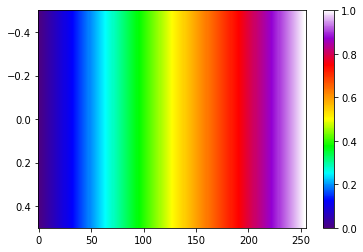

In [1]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import pyvista as pv

# Définir les couleurs du bas au haut de la colormap de l'image
colors = [
    (75/255, 0, 130/255),   # indigo
    (0, 0, 255/255),        # bleu
    (0, 255/255, 255/255),  # cyan
    (0, 255/255, 0),        # vert
    (255/255, 255/255, 0),  # jaune
    (255/255, 127/255, 0),  # orange
    (255/255, 0 , 0),        # rouge
    (148/255, 0, 211/255),  # violet
    (1, 1, 1)               # blanc

]

cmap_name = 'custom_gradient'

# Créer la colormap
custom_cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=256)


# Afficher la colormap dans Matplotlib
plt.imshow(np.linspace(0, 1, 256)[None, :], aspect='auto', cmap=custom_cmap)
plt.colorbar()
plt.show()


In [2]:
import os
import feelpp
from feelpp.toolboxes.cfpdes import *
from tools.lap2D_pinns import Run_laplacian2D, Poisson_2D, PoissonDisk2D
from scimba.equations import domain
from tools.GeoToMsh import geo_to_msh
from tools.GmeshRead import mesh2d

import pandas as pd
import numpy as np

import plotly.express as px
from plotly.subplots import make_subplots
import itertools
import torch
from pathlib import Path

class Poisson:
  """
  Solves the problem
  -Laplacian u = f   in Omega
  u            = g   in boundary
  
  - with f,g are set by the user
  """
  def __init__(self, dim=2, order=1):

    self.dim   = dim
    self.model = dict()
    self.order = order  
##______________________________________________________________________________________________

  def genCube(self, filename, h=0.1):
    """
    Generate a cube geometry following the dimension  self.dim
    """

    
    geo="""SetFactory("OpenCASCADE");
    h={};
    dim={};
    """.format(h, self.dim)
    
    if self.dim==2 :
      geo+="""
      Rectangle(1) = {0, 0, 0, 1, 1, 0};
      Characteristic Length{ PointsOf{ Surface{1}; } } = h;
      Physical Curve("Gamma_D") = {1,2,3,4};
      Physical Surface("Omega") = {1};
      """
    elif self.dim==3 :
      geo+="""
      Box(1) = {0, 0, 0, 1, 1, 1};
      Characteristic Length{ PointsOf{ Volume{1}; } } = h;
      Physical Surface("Gamma_D") = {1,2,3,4,5,6};
      Physical Volume("Omega") = {1};
      """
    with open(filename, 'w') as f:
      f.write(geo)

##______________________________________________________________________________________________

  def getMesh(self, filename,hsize=0.05,dim=2,verbose=False):
    """create mesh

    Args:
        filename (str): name of the file
        hsize (float): mesh size
        dim (int): dimension of the mesh
        verbose (bool): verbose mode
    """
    import os
    for ext in [".msh",".geo"]:
      f=os.path.splitext(filename)[0]+ext
      if os.path.exists(f):
        os.remove(f)
    if verbose:
      print(f"generate mesh {filename} with hsize={hsize} and dimension={dim}")
    self.genCube(filename=filename, h=hsize)
    mesh = feelpp.load(feelpp.mesh(dim=dim,realdim=dim), filename, hsize)
    return mesh

##______________________________________________________________________________________________

  def feel_solver(self, filename, h, json, dim=2,verbose=False):
    if verbose:
      print(f"Solving the laplacian problem for hsize = {h}...")
    self.pb.setMesh(self.getMesh(filename,hsize=h,dim=dim,verbose=verbose))
    self.pb.setModelProperties(json)
    self.pb.init(buildModelAlgebraicFactory=True)
    self.pb.printAndSaveInfo()
    self.pb.solve()
    self.pb.exportResults()
    measures = self.pb.postProcessMeasures().values()
    return measures
  
##______________________________________________________________________________________________

  def scimba_solver(self, filename, h, json, dim = 2, verbose=False):
    if verbose:
      print(f"Solving the laplacian problem for hsize = {h}...")    
    """
    if filename == 'geo/disk.geo':
      xdomain = domain.SpaceDomain(2, domain.DiskBasedDomain(2, center=[0.0, 0.0], radius=1.0))
      pde = PoissonDisk2D(xdomain, rhs=self.rhs, diff=diff, g=self.g, u_exact=self.u_exact)
    elif filename is None:
    """
    diff = self.diff.replace('{', '(').replace('}', ')')
    xdomain = domain.SpaceDomain(2, domain.SquareDomain(2, [[0.0, 1.0], [0.0, 1.0]]))
    pde = Poisson_2D(xdomain, rhs=self.rhs, diff=diff, g=self.g, u_exact=self.u_exact)
    network, pde = Run_laplacian2D(pde)

    # Extract solution function u
    u = network.forward

    # Get mesh points
    geo_to_msh(filename, f"omega-{dim}d.msh", mesh_size=h)
    mesh = f"omega-{dim}d.msh"
    my_mesh = mesh2d(mesh)
    my_mesh.read_mesh()
    coordinates = my_mesh.Nodes

    # Evaluate the network on mesh points
    input_tensor = torch.tensor(coordinates, dtype=torch.double)
    mu = torch.tensor([[0.5]]).repeat(input_tensor.size(0), 1)  # Example mu values
    solution_tensor = u(input_tensor, mu)

    # Convert the tensor to a NumPy array
    solution_array = solution_tensor.detach().numpy()

    # Update model with the solution array if needed
    self.model["PostProcess"][f"cfpdes-{self.dim}d-p{self.order}"]["Exports"]["expr"]["u"] = solution_array

    return solution_array

##______________________________________________________________________________________________
  
  def __call__(self,
               h=0.1,                                       # mesh size 
               order=1,                                 # polynomial order 
               name='u',                                # name of the variable u
               rhs='8*pi*pi*sin(2*pi*x)*sin(2*pi*y)',   # right hand side
               diff='{1,0,0,1}',                        # diffusion matrix
               g='0',
               geofile=None,
               plot=None,
               solver='feelpp',
               u_exact='sin(2 * pi * x) * sin(2 * pi * y)',
               grad_u_exact = '{2*pi*cos(2*pi*x)*sin(2*pi*y),2*pi*sin(2*pi*x)*cos(2*pi*y)}' 
               ):
    """
    Solves the problem where :
    - h is the mesh size
    - order the polynomial order
    - rhs is the expression of the right-hand side f(x,y)
    """
    self.measures = dict()
    self.rhs = rhs
    self.g = g
    self.u_exact = u_exact
    self.diff = diff
    self.pb    = cfpdes(dim=self.dim, keyword=f"cfpdes-{self.dim}d-p{self.order}")
    self.model = {
      "Name": "Laplacian",
      "ShortName": "Laplacian",
      "Models":
      {
        f"cfpdes-{self.dim}d-p{self.order}":
        {
          "equations":"poisson"
        },
        "poisson":{
          "setup":{
            "unknown":{
              "basis":f"Pch{order}",
              "name":f"{name}",
              "symbol":"u"
            },
            "coefficients":{
              "c": f"{diff}:x:y" if self.dim == 2 else f"{diff}:x:y:z",
              "f": f"{rhs}:x:y"  if self.dim == 2 else f"{rhs}:x:y:z"
            }
          }
        }
      },
      "Materials":
      {
        "Omega":
        {
          "markers":["Omega"]
        }
      },
      "BoundaryConditions":
      {
        "poisson":
        {
          "Dirichlet":
          {
            "g":
            {
              "markers":["Gamma_D"],
              "expr":f"{g}:x:y"
            }
          }
        }
      },
      "PostProcess":
      {
        f"cfpdes-{self.dim}d-p{self.order}":
        {
          "Exports":
          {
            "fields":["all"],
            "expr":{
              #"u": f"{name}:x:y" if self.dim == 2 else f"{name}:x:y:z",         
              "rhs": f"{rhs}:x:y" if self.dim == 2 else f"{rhs}:x:y:z",
              "u_exact" : f"{u_exact}:x:y" if self.dim==2 else f"{u_exact}:x:y:z",
              "grad_u_exact" : f"{grad_u_exact}:x:y" if self.dim==2 else f"{grad_u_exact}:x:y:z",
            }
          },
            "Measures" :
            {
              "Norm" :
              {
                  "poisson" :
                  {
                     "type":["L2-error", "H1-error"],
                     "field":f"poisson.{name}",
                     "solution": f"{u_exact}:x:y" if self.dim==2 else f"{u_exact}:x:y:z",
                     "grad_solution": f"{grad_u_exact}:x:y" if self.dim==2 else f"{grad_u_exact}:x:y:z",
                     "markers":"Omega",
                     "quad":6
                 }
              },
                "Statistics":
                {
                    "mystatA":
                    {
                        "type":["min","max","mean","integrate"],
                        "field":f"poisson.{name}"
                    }
                }
            }
        }
      }
    }

    fn = None
    if geofile is None:
      fn = f'omega-{self.dim}.geo'
      self.genCube(fn, h)
    else:
      fn = geofile      
##________________________

  # Solving

    if solver == 'feelpp':
      self.measures = self.feel_solver(filename=fn, h=h, json=self.model, dim=self.dim, verbose=True)
    elif solver == 'scimba':
      solution = self.scimba_solver(filename=fn, h=h, json=self.model, dim=self.dim, verbose=True)
      print('solution = ', solution)
##________________________

     
    # Plots
    if plot != None:
      
      from xvfbwrapper import Xvfb
      import pyvista as pv 
      import matplotlib.pyplot as plt


      vdisplay = Xvfb()
      vdisplay.start()
      pv.set_jupyter_backend('static') 
      #pv.start_xvfb()
      def pv_get_mesh(mesh_path):
          reader = pv.get_reader(mesh_path)
          mesh = reader.read()
          return mesh

      def pv_plot(mesh, field, clim=None, cmap=custom_cmap, cpos='xy', show_scalar_bar=True, show_edges=True):
          mesh.plot(scalars=field, clim=clim, cmap=cmap, cpos=cpos, show_scalar_bar=show_scalar_bar, show_edges=show_edges)

      def myplots(dim=2, field=f"cfpdes.poisson.{name}", factor=1, cmap=custom_cmap):
          mesh = pv_get_mesh((f"cfpdes-{self.dim}d-p{self.order}.exports/Export.case"))
          #pv_plot(mesh, field)
          pl = pv.Plotter(shape=(1,2))

          pl.add_title(f'Solution P{order}', font_size=18)
          pl.add_mesh(mesh[0], scalars = f"cfpdes.poisson.{name}", cmap=custom_cmap)

          pl.subplot(0,1)
          pl.add_title('u_exact=' + u_exact, font_size=10)
          pl.add_mesh(mesh[0].copy(), scalars = 'cfpdes.expr.u_exact', cmap=custom_cmap)

          
          pl.link_views()
          pl.view_xy()
          pl.show()
          pl.screenshot(plot)
          """
          pl = pv.Plotter()
          #contours = mesh[0].contour()
          #pl.add_mesh(mesh[0], opacity=0.85, cmap=custom_cmap)
          #pl.add_mesh(contours, color="white", line_width=3, render_lines_as_tubes=True)
          pl.show()
          if dim == 2:
              warped = mesh[0].warp_by_scalar(field, factor=factor)
              warped.plot(cmap=custom_cmap, show_scalar_bar=False, show_edges=True)
          else:
              slices = mesh.slice_orthogonal(x=0.2,y=0.4,z=.6)
              slices.plot()
          """

      """
      mesh = pv.get_reader(f"cfpdes-{self.dim}d-p{self.order}.exports/Export.case").read()
      
      pl = pv.Plotter(shape=(1,2))
      pl.add_title(f'Solution P{order}', font_size=18)
      pl.add_mesh(mesh[0], scalars = f"cfpdes.poisson.{name}", cmap=custom_cmap)
      pl.subplot(0,1)
      pl.add_title('u=' + u_exact, font_size=10)
      pl.add_mesh(mesh[0].copy(), scalars = 'cfpdes.expr.u_exact', cmap=custom_cmap)
      pl.link_views()

      if self.dim ==3:
        pl.view_isometric()
      else:
        pl.view_xy()  # if mesh_2D is on the xy plane.        
      
      pl.show()
      pl.screenshot(plot)
      """
      myplots(dim=2,factor=0.5)


Using device: cpu
torch loaded; device is cpu
Info    : Reading '/workspaces/2024-m1-scimba-feelpp/geo/disk.geo'...
Info    : Done reading '/workspaces/2024-m1-scimba-feelpp/geo/disk.geo'
Info    : Meshing 1D...
Info    : Meshing curve 1 (Ellipse)
Info    : Done meshing 1D (Wall 0.00018837s, CPU 0.001957s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0367044s, CPU 0.088289s)
Info    : 411 nodes 821 elements
Info    : Writing '/workspaces/2024-m1-scimba-feelpp/geo/disk.msh'...
Info    : Done writing '/workspaces/2024-m1-scimba-feelpp/geo/disk.msh'


In [3]:
import sys
import feelpp
import feelpp.toolboxes.core as tb

# mandatory things
sys.argv = ["feelpp_app"]
e = feelpp.Environment(sys.argv,
                       opts=tb.toolboxes_options("coefficient-form-pdes", "cfpdes"),
                       config=feelpp.localRepository('feelpp_cfpde'))

# ------------------------------------------------------------------------- #
# Poisson problem
# - div (diff * grad (u)) = f    in Omega
#                     u   = g    in Gamma_D
# Omega = domain, either cube or ball
# Approx = lagrange Pk of order order
# mesh of size h



[ Starting Feel++ ] application feelpp_app version 0.1 date 2024-Jun-02
 . feelpp_app files are stored in /workspaces/2024-m1-scimba-feelpp/feelppdb/feelpp_cfpde/np_1
 .. logfiles :/workspaces/2024-m1-scimba-feelpp/feelppdb/feelpp_cfpde/np_1/logs


Solving the laplacian problem for hsize = 0.1...
>> load network /workspaces/2024-m1-scimba-feelpp/feelppdb/feelpp_cfpde/np_1/networks/test.pth
network was not loaded from file: training needed
epoch     0: current loss = 1.93e+02
epoch     0: best loss = 1.93e+02
epoch     1: best loss = 1.93e+02
epoch     2: best loss = 1.91e+02
epoch     3: best loss = 1.84e+02
epoch     4: best loss = 1.76e+02
epoch     5: best loss = 1.59e+02
epoch     6: best loss = 1.36e+02
epoch     7: best loss = 1.06e+02
epoch     8: best loss = 8.38e+01
epoch    11: best loss = 7.27e+01
epoch    12: best loss = 6.15e+01
epoch    16: best loss = 5.16e+01
epoch    17: best loss = 4.58e+01
epoch    18: best loss = 4.47e+01
epoch    19: best loss = 3.80e+01
epoch    20: best loss = 3.79e+01
epoch    22: best loss = 3.20e+01
epoch    23: best loss = 2.60e+01
epoch    24: best loss = 2.52e+01
epoch    25: best loss = 2.41e+01
epoch    26: best loss = 2.22e+01
epoch    27: best loss = 2.00e+01
epoch    28: best los

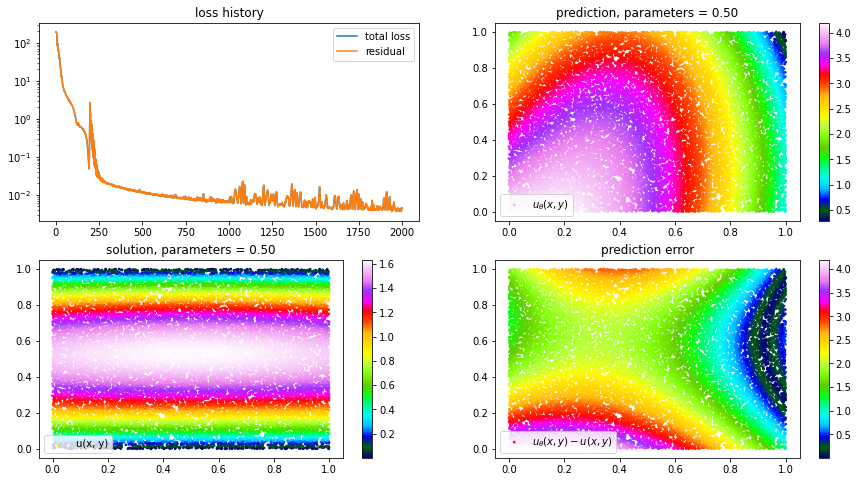

Info    : Reading 'omega-2.geo'...
Info    : Done reading 'omega-2.geo'
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 30%] Meshing curve 2 (Line)
Info    : [ 60%] Meshing curve 3 (Line)
Info    : [ 80%] Meshing curve 4 (Line)
Info    : Done meshing 1D (Wall 0.000245908s, CPU 0.000503s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.00517696s, CPU 0.005248s)
Info    : 144 nodes 290 elements
Info    : Writing 'omega-2d.msh'...
Info    : Done writing 'omega-2d.msh'
solution =  [[4.12451245]
 [1.13076371]
 [0.22330487]
 [1.76528958]
 [4.19333205]
 [4.17732886]
 [4.07779036]
 [3.89616023]
 [3.63377654]
 [3.29164999]
 [2.87032316]
 [2.36986407]
 [1.79004758]
 [1.1779972 ]
 [1.1930175 ]
 [1.17975445]
 [1.14017378]
 [1.0742161 ]
 [0.97987169]
 [0.85337068]
 [0.6894669 ]
 [0.481797  ]
 [1.00349424]
 [1.65564768]
 [2.17176989]
 [2.54679714]
 [2.77785201]
 [2.86359424]
 [2.80378163]
 [2.59915162]
 [2.25

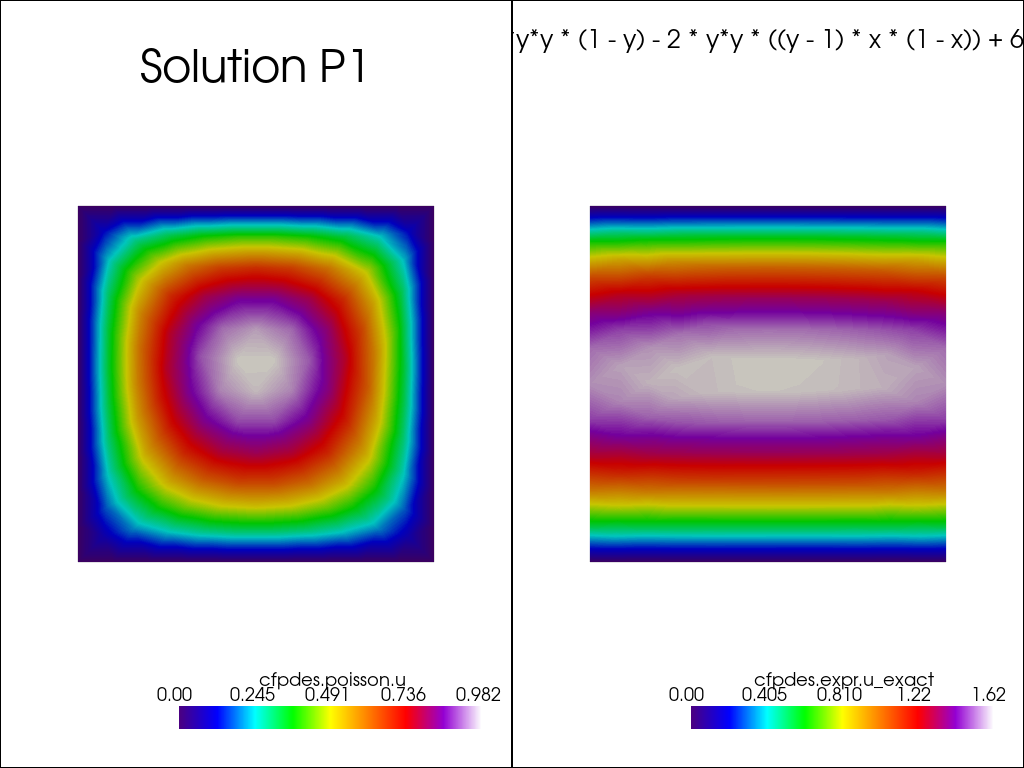

In [4]:
u_exact = 'y*y*y * (1 - y) - 2 * y*y * ((y - 1) * x * (1 - x)) + 6 * y * (1 - y)'
rhs='-2 * (-6 + x * (2 - 6 * y) + 3 * y - 8 * y*y + 2 * y*y*y + x*x * (-2 + 6 * y))'

P = Poisson(dim = 2)
P(rhs=rhs, g='0', order=1, solver='scimba', u_exact = u_exact)
P(rhs=rhs, g='0', order=1, plot='f4.png', u_exact = u_exact)


In [5]:
    

##________________________

# Convergence

def runLaplacianPk(P, df,model, verbose=False):
  """generate the Pk case

  Args:
      order (int, optional): order of the basis. Defaults to 1.
  """
  meas=dict()
  dim,order,json=model
  for h in df['h']:
    m= P.measures #P.feel_solver(h=h,json=json,dim=dim,verbose=verbose)
    for norm in ['L2','H1']:
      meas.setdefault(f'P{order}-Norm_poisson_{norm}-error', [])
      meas[f'P{order}-Norm_poisson_{norm}-error'].append(m.pop(f'Norm_poisson_{norm}-error'))
  df=df.assign(**meas)
  for norm in ['L2','H1']:
    df[f'P{order}-poisson_{norm}-convergence-rate']=np.log2(df[f'P{order}-Norm_poisson_{norm}-error'].shift() / df[f'P{order}-Norm_poisson_{norm}-error']) / np.log2(df['h'].shift() / df['h'])
  return df


In [6]:
def runLaplacianPk(P, df, model, verbose=False):
    """Generate the Pk case"""
    meas = dict()
    dim, order, json = model

    for h in df['h']:
        m = P.measures #P.feel_solver(h=h, json=json, dim=dim, verbose=verbose)
        if m is None:
            print(f"Warning: Solver returned None for h={h}")
            continue

        for norm in ['L2', 'H1']:
            error_key = f'Norm_poisson_{norm}-error'
            if error_key not in m:
                print(f"Warning: '{error_key}' not found in solver output")
                continue

            meas.setdefault(f'P{order}-Norm_poisson_{norm}-error', [])
            meas[f'P{order}-Norm_poisson_{norm}-error'].append(m[error_key])

    df = df.assign(**meas)

    # Calculate convergence rates where possible
    for norm in ['L2', 'H1']:
        error_series = f'P{order}-Norm_poisson_{norm}-error'
        if error_series in df and len(df[error_series]) > 1:
            rate_series = f'P{order}-poisson_{norm}-convergence-rate'
            rates = np.log2(df[error_series].shift() / df[error_series]) / np.log2(df['h'].shift() / df['h'])
            df[rate_series] = rates.fillna(0)  # Replace NaNs with zero or another suitable value

    return df
def runConvergenceAnalysis(P, json,dim=2,hs=[0.1,0.05,0.025],order='1',verbose=False):
  df=pd.DataFrame({'h':hs})
  df=runLaplacianPk(P, df=df,model=[dim,order,json(dim=dim,order=order)],verbose=verbose)
  print(df.to_markdown())
  return df

#laplacian_json = lambda order,dim=2,name="u": P.model
#df= runConvergenceAnalysis(P, json=laplacian_json,dim=2,verbose=True)



def plot_convergence(P, df,dim,orders=[1]):
  fig=px.line(df, x="h", y=[f'P{order}-Norm_poisson_{norm}-error' for order,norm in list(itertools.product(orders,['L2','H1']))])
  fig.update_xaxes(title_text="h",type="log")
  fig.update_yaxes(title_text="Error",type="log")
  for order,norm in list(itertools.product(orders,['L2','H1'])):
    fig.update_traces(name=f'P{order} - {norm} error - {df[f"P{order}-poisson_{norm}-convergence-rate"].iloc[-1]:.2f}', selector=dict(name=f'P{order}-Norm_poisson_{norm}-error'))
  fig.update_layout(
          title=f"Convergence rate for the {dim}D Laplacian problem",
          autosize=False,
          width=900,
          height=900,
      )
  return fig
#fig= plot_convergence(P, df,dim=2)
#fig.show()



In [7]:
laplacian_json = lambda order,dim=2,name="u": P.model
"""
with open(f'poisson-{P.dim}d.json', 'w') as f:
      # Write the string to the file
      import json
      f.write(json.dumps(laplacian_json(dim=P.dim,order=1),indent=1))
      # execute the laplacian problem using P1 basis on a mesh of the unit square  of size 0.1
      print('lap  =', P.measures)
"""
json=laplacian_json

model=[P.dim,P.order,json(dim=P.dim,order=P.order)]
print(model)
hs=[0.1,0.05,0.025,0.0125]
df=pd.DataFrame({'h':hs})


df= runLaplacianPk(P, df=df, model=model, verbose=True)
df= runConvergenceAnalysis( P, json=json,dim=2,verbose=True)


[2, 1, {'Name': 'Laplacian', 'ShortName': 'Laplacian', 'Models': {'cfpdes-2d-p1': {'equations': 'poisson'}, 'poisson': {'setup': {'unknown': {'basis': 'Pch1', 'name': 'u', 'symbol': 'u'}, 'coefficients': {'c': '{1,0,0,1}:x:y', 'f': '-2 * (-6 + x * (2 - 6 * y) + 3 * y - 8 * y*y + 2 * y*y*y + x*x * (-2 + 6 * y)):x:y'}}}}, 'Materials': {'Omega': {'markers': ['Omega']}}, 'BoundaryConditions': {'poisson': {'Dirichlet': {'g': {'markers': ['Gamma_D'], 'expr': '0:x:y'}}}}, 'PostProcess': {'cfpdes-2d-p1': {'Exports': {'fields': ['all'], 'expr': {'rhs': '-2 * (-6 + x * (2 - 6 * y) + 3 * y - 8 * y*y + 2 * y*y*y + x*x * (-2 + 6 * y)):x:y', 'u_exact': 'y*y*y * (1 - y) - 2 * y*y * ((y - 1) * x * (1 - x)) + 6 * y * (1 - y):x:y', 'grad_u_exact': '{2*pi*cos(2*pi*x)*sin(2*pi*y),2*pi*sin(2*pi*x)*cos(2*pi*y)}:x:y'}}, 'Measures': {'Norm': {'poisson': {'type': ['L2-error', 'H1-error'], 'field': 'poisson.u', 'solution': 'y*y*y * (1 - y) - 2 * y*y * ((y - 1) * x * (1 - x)) + 6 * y * (1 - y):x:y', 'grad_soluti

In [8]:
fig= plot_convergence(P, df,dim=2)
fig.show()



Solving the laplacian problem for hsize = 0.1...
generate mesh omega-2.geo with hsize=0.1 and dimension=2
[loadMesh] Loading mesh in format geo+msh: "/workspaces/2024-m1-scimba-feelpp/feelppdb/feelpp_cfpde/np_1/omega-2.geo"
[loadMesh] Use default geo desc: /workspaces/2024-m1-scimba-feelpp/feelppdb/feelpp_cfpde/np_1/omega-2.geo 0.1 
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Toolbox::cfpdes-2d-p1 - Use Case Study                                                                                                                 |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| +--------------------------------------------------------------------------------------+                                                               |
| | Environment                              

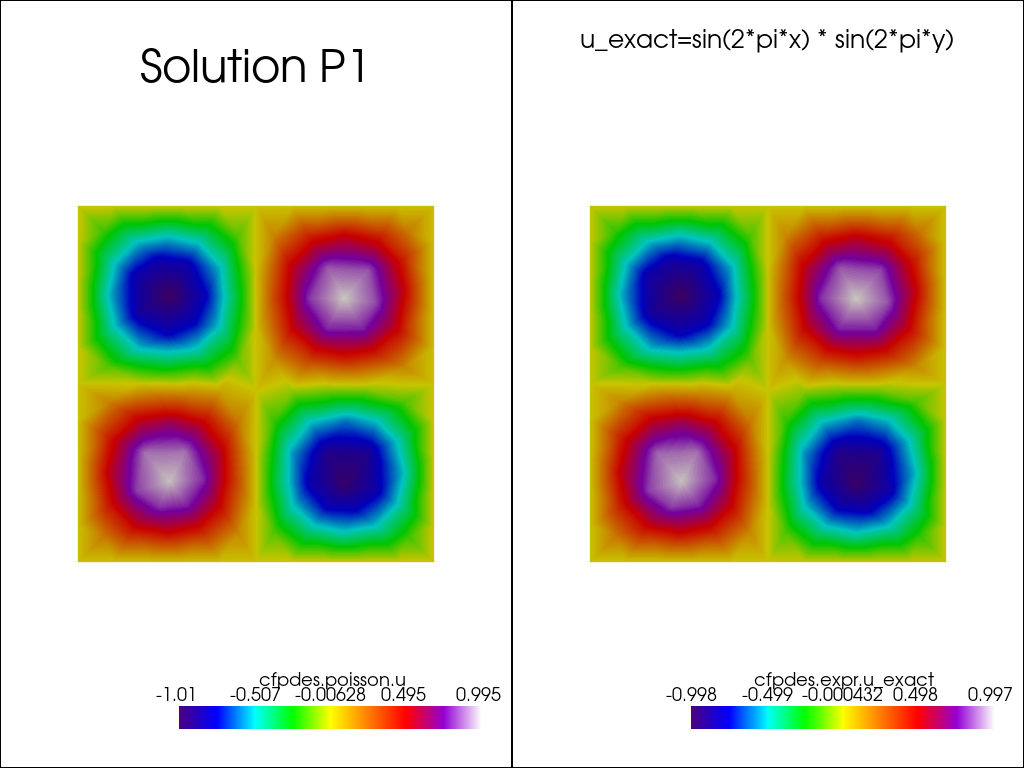

Solving the laplacian problem for hsize = 0.1...
>> load network /workspaces/2024-m1-scimba-feelpp/feelppdb/feelpp_cfpde/np_1/networks/test.pth
network was not loaded from file: training needed
epoch     0: current loss = 1.57e+03
epoch     0: best loss = 1.57e+03
epoch     3: best loss = 1.53e+03
epoch     5: best loss = 1.49e+03
epoch     6: best loss = 1.45e+03
epoch     7: best loss = 1.34e+03
epoch     8: best loss = 1.11e+03
epoch     9: best loss = 1.06e+03
epoch    10: best loss = 1.06e+03
epoch    11: best loss = 9.26e+02
epoch    15: best loss = 8.85e+02
epoch    19: best loss = 8.55e+02
epoch    24: best loss = 8.41e+02
epoch    25: best loss = 8.28e+02
epoch    26: best loss = 8.07e+02
epoch    29: best loss = 7.96e+02
epoch    31: best loss = 7.87e+02
epoch    33: best loss = 7.69e+02
epoch    38: best loss = 7.52e+02
epoch    42: best loss = 7.47e+02
epoch    43: best loss = 7.38e+02
epoch    44: best loss = 7.33e+02
epoch    46: best loss = 7.32e+02
epoch    49: best los

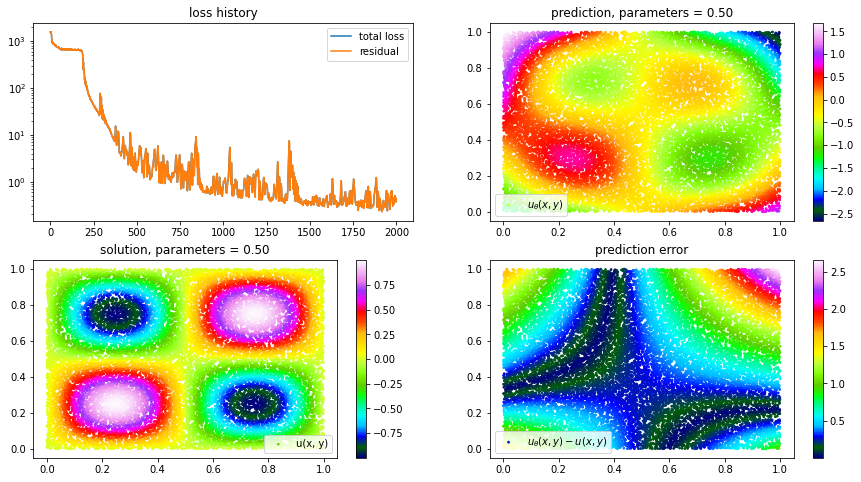

Info    : Reading 'omega-2.geo'...
Info    : Done reading 'omega-2.geo'
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 30%] Meshing curve 2 (Line)
Info    : [ 60%] Meshing curve 3 (Line)
Info    : [ 80%] Meshing curve 4 (Line)
Info    : Done meshing 1D (Wall 0.000219656s, CPU 0.000297s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.00467063s, CPU 0.004696s)
Info    : 144 nodes 290 elements
Info    : Writing 'omega-2d.msh'...
Info    : Done writing 'omega-2d.msh'
solution =  [[-1.53010218]
 [ 0.97072967]
 [-2.68717841]
 [ 1.72718891]
 [-1.28211964]
 [-1.00033362]
 [-0.71608251]
 [-0.45200971]
 [-0.21041357]
 [ 0.01854285]
 [ 0.24140915]
 [ 0.4633501 ]
 [ 0.70183168]
 [ 0.50656653]
 [ 0.07804424]
 [-0.27637341]
 [-0.568165  ]
 [-0.83897898]
 [-1.12855287]
 [-1.45784627]
 [-1.83339506]
 [-2.25165046]
 [-2.24733581]
 [-1.81329268]
 [-1.38700068]
 [-0.95381849]
 [-0.49904891]
 [-0.02375201]
 [ 0.4

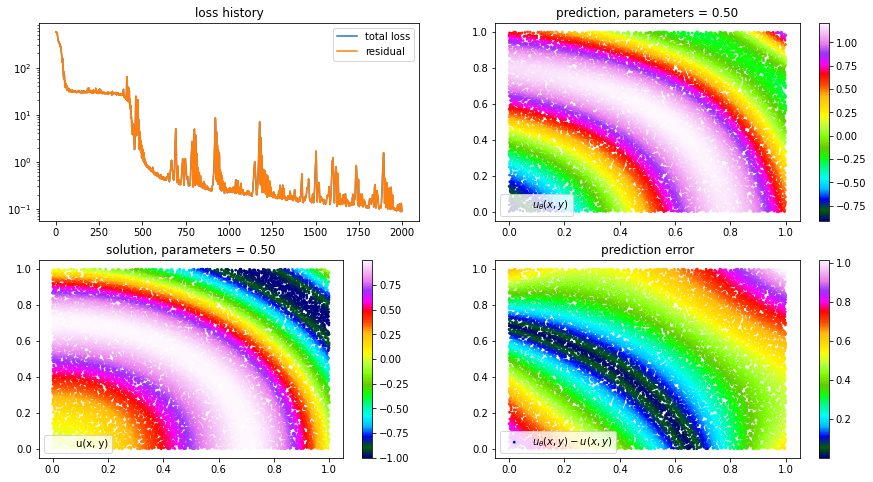

Info    : Reading '/workspaces/2024-m1-scimba-feelpp/geo/disk.geo'...
Info    : Done reading '/workspaces/2024-m1-scimba-feelpp/geo/disk.geo'
Info    : Meshing 1D...
Info    : Meshing curve 1 (Ellipse)
Info    : Done meshing 1D (Wall 0.000101492s, CPU 0.000147s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0149792s, CPU 0.014965s)
Info    : 411 nodes 821 elements
Info    : Writing 'omega-2d.msh'...
Info    : Done writing 'omega-2d.msh'
solution =  [[ 0.57879098]
 [ 0.51320443]
 [ 0.47524769]
 [ 0.46206307]
 [ 0.46766013]
 [ 0.48412494]
 [ 0.50312256]
 [ 0.51749667]
 [ 0.52264678]
 [ 0.51743887]
 [ 0.50452018]
 [ 0.48992153]
 [ 0.48185951]
 [ 0.48887856]
 [ 0.51782507]
 [ 0.57233094]
 [ 0.65226061]
 [ 0.75388643]
 [ 0.86960689]
 [ 0.98557043]
 [ 1.07708028]
 [ 1.10597428]
 [ 1.02810535]
 [ 0.81489365]
 [ 0.47801989]
 [ 0.07462462]
 [-0.31729797]
 [-0.63430595]
 [-0.84634494]
 [-0.95347298]
 [-0.97327801]
 [-0.9299077 ]
 

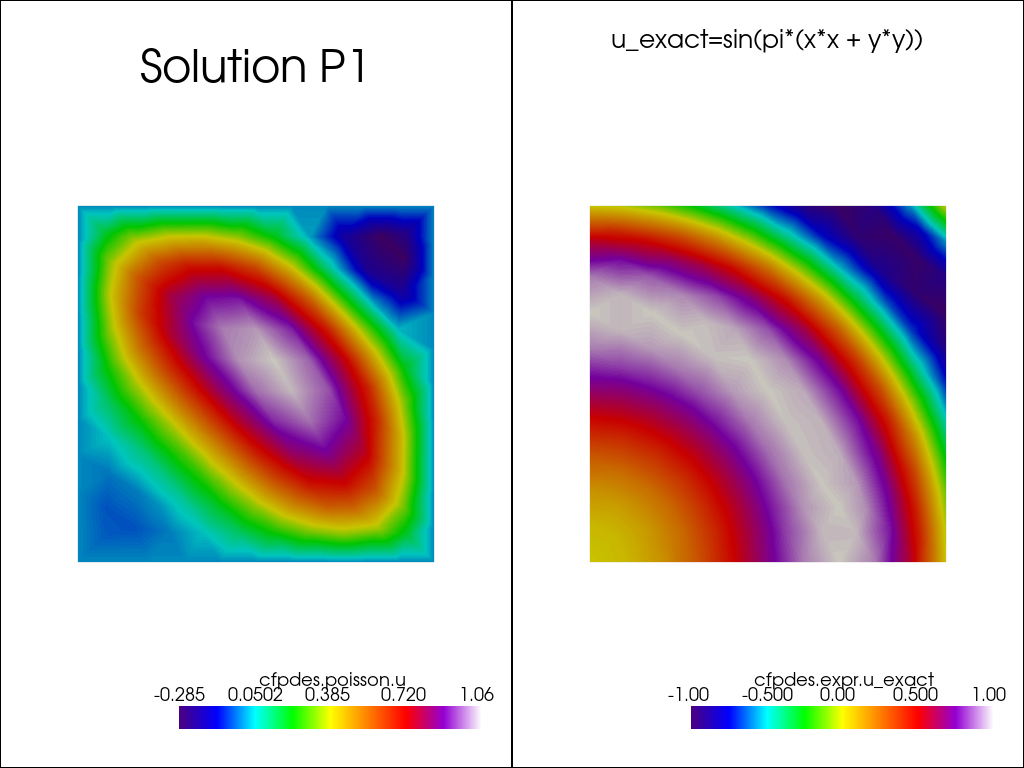

In [9]:



# 2D on different domains
P = Poisson(dim = 2)

# for square domain
u_exact = 'sin(2*pi*x) * sin(2*pi*y)'
rhs = '8*pi*pi*sin(2*pi*x) * sin(2*pi*y)'

P(rhs=rhs, g='0', order=1, plot='f2.png', u_exact = u_exact)
P(rhs=rhs, g='0', order=1, solver ='scimba', u_exact = u_exact)

# for disk domain
u_exact =  'sin(pi*(x*x + y*y))'
rhs = '4* pi * (-cos(pi* (x*x + y*y)) + pi * (x*x + y*y)* sin(pi* (x*x + y*y)))'
P(rhs=rhs, g='0', order=1, geofile='/workspaces/2024-m1-scimba-feelpp/geo/disk.geo', solver='scimba', u_exact = u_exact)
P(rhs=rhs, g='0', order=1, geofile='/workspaces/2024-m1-scimba-feelpp/geo/disk.geo', plot='2d.png', u_exact = u_exact)





Solving the laplacian problem for hsize = 0.1...
generate mesh omega-2.geo with hsize=0.1 and dimension=2
[loadMesh] Loading mesh in format geo+msh: "/workspaces/2024-m1-scimba-feelpp/feelppdb/feelpp_cfpde/np_1/omega-2.geo"
[loadMesh] Use default geo desc: /workspaces/2024-m1-scimba-feelpp/feelppdb/feelpp_cfpde/np_1/omega-2.geo 0.1 
+------------------------------------------------------------------------------------------------------------------------------------+
| Toolbox::cfpdes-2d-p1 - Use Case Study                                                                                             |
+------------------------------------------------------------------------------------------------------------------------------------+
| +--------------------------------------------------------------------------------------+                                           |
| | Environment                                                                          |                                   

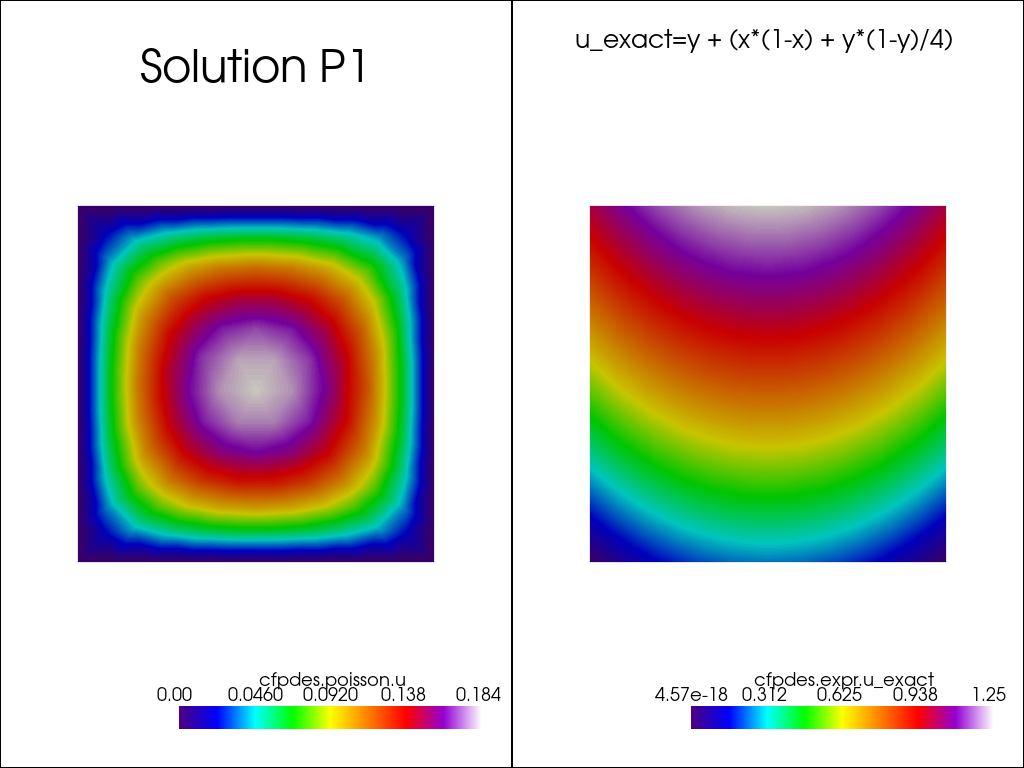

Solving the laplacian problem for hsize = 0.1...
>> load network /workspaces/2024-m1-scimba-feelpp/feelppdb/feelpp_cfpde/np_1/networks/test.pth
network was not loaded from file: training needed
epoch     0: current loss = 6.26e+00
epoch     0: best loss = 6.26e+00
epoch     1: best loss = 6.03e+00
epoch     2: best loss = 5.61e+00
epoch     3: best loss = 4.78e+00
epoch     4: best loss = 3.41e+00
epoch     5: best loss = 1.57e+00
epoch     6: best loss = 1.50e-01
epoch    25: best loss = 1.48e-01
epoch    26: best loss = 1.09e-01
epoch    27: best loss = 8.68e-02
epoch    28: best loss = 8.12e-02
epoch    29: best loss = 7.71e-02
epoch    32: best loss = 7.20e-02
epoch    33: best loss = 6.63e-02
epoch    34: best loss = 5.57e-02
epoch    35: best loss = 5.31e-02
epoch    36: best loss = 4.69e-02
epoch    37: best loss = 4.23e-02
epoch    38: best loss = 4.05e-02
epoch    41: best loss = 4.00e-02
epoch    42: best loss = 3.80e-02
epoch    43: best loss = 3.61e-02
epoch    44: best los

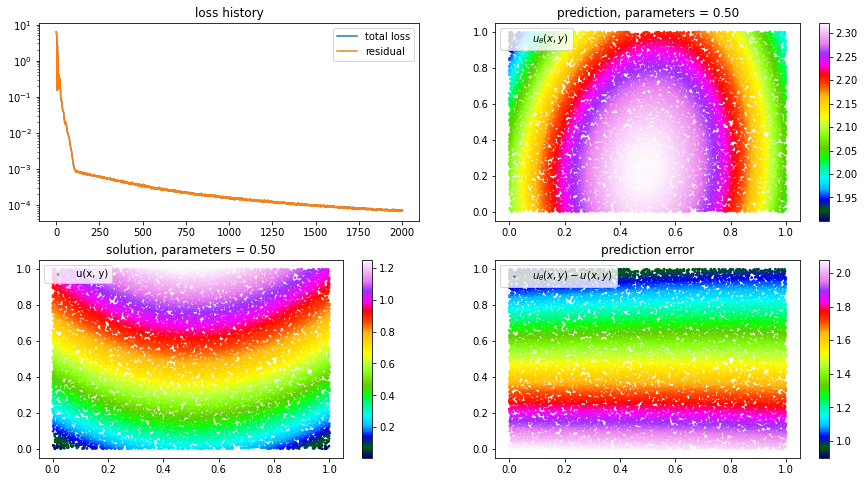

Info    : Reading 'omega-2.geo'...
Info    : Done reading 'omega-2.geo'
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 30%] Meshing curve 2 (Line)
Info    : [ 60%] Meshing curve 3 (Line)
Info    : [ 80%] Meshing curve 4 (Line)
Info    : Done meshing 1D (Wall 0.000247299s, CPU 0.000332s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.00466417s, CPU 0.004716s)
Info    : 144 nodes 290 elements
Info    : Writing 'omega-2d.msh'...
Info    : Done writing 'omega-2d.msh'
solution =  [[2.07730013]
 [2.03249535]
 [1.97813662]
 [1.89737664]
 [2.1635711 ]
 [2.2301159 ]
 [2.27673064]
 [2.3032921 ]
 [2.30968342]
 [2.29574815]
 [2.26127747]
 [2.20603286]
 [2.12980364]
 [2.0416344 ]
 [2.04736652]
 [2.04978246]
 [2.04895625]
 [2.04494579]
 [2.03779363]
 [2.02752793]
 [2.01416339]
 [1.99770247]
 [2.06619355]
 [2.13260682]
 [2.17747254]
 [2.20094852]
 [2.20317782]
 [2.18424656]
 [2.14417878]
 [2.08296853]
 [2.00

"\n\nP( rhs='-1.0-3*y*x+y*y', g='y', order=1, plot='f3.png')\nP( rhs='-1.0-3*y*x+y*y', g='y', order=1, solver ='scimba')\n\n\nP( rhs='-1.0-4*y*x+y*y', g='x', order=1, plot='f4.png')\nP( rhs='-1.0-4*y*x+y*y', g='x', order=1, solver ='scimba')\n\n"

In [10]:

u_exact = 'y + (x*(1-x) + y*(1-y)/4) '
P(rhs='5/2',              g='0', order=1, plot='f5.png', u_exact = u_exact)
P(rhs='5/2',              g='0', order=1, solver ='scimba', u_exact = u_exact)


"""

P( rhs='-1.0-3*y*x+y*y', g='y', order=1, plot='f3.png')
P( rhs='-1.0-3*y*x+y*y', g='y', order=1, solver ='scimba')


P( rhs='-1.0-4*y*x+y*y', g='x', order=1, plot='f4.png')
P( rhs='-1.0-4*y*x+y*y', g='x', order=1, solver ='scimba')

"""


Solving the laplacian problem for hsize = 0.1...
generate mesh omega-2.geo with hsize=0.1 and dimension=2
[loadMesh] Loading mesh in format geo+msh: "/workspaces/2024-m1-scimba-feelpp/feelppdb/feelpp_cfpde/np_1/omega-2.geo"
[loadMesh] Use default geo desc: /workspaces/2024-m1-scimba-feelpp/feelppdb/feelpp_cfpde/np_1/omega-2.geo 0.1 
+---------------------------------------------------------------------------------------------------------------------------------------+
| Toolbox::cfpdes-2d-p1 - Use Case Study                                                                                                |
+---------------------------------------------------------------------------------------------------------------------------------------+
| +--------------------------------------------------------------------------------------+                                              |
| | Environment                                                                          |                       

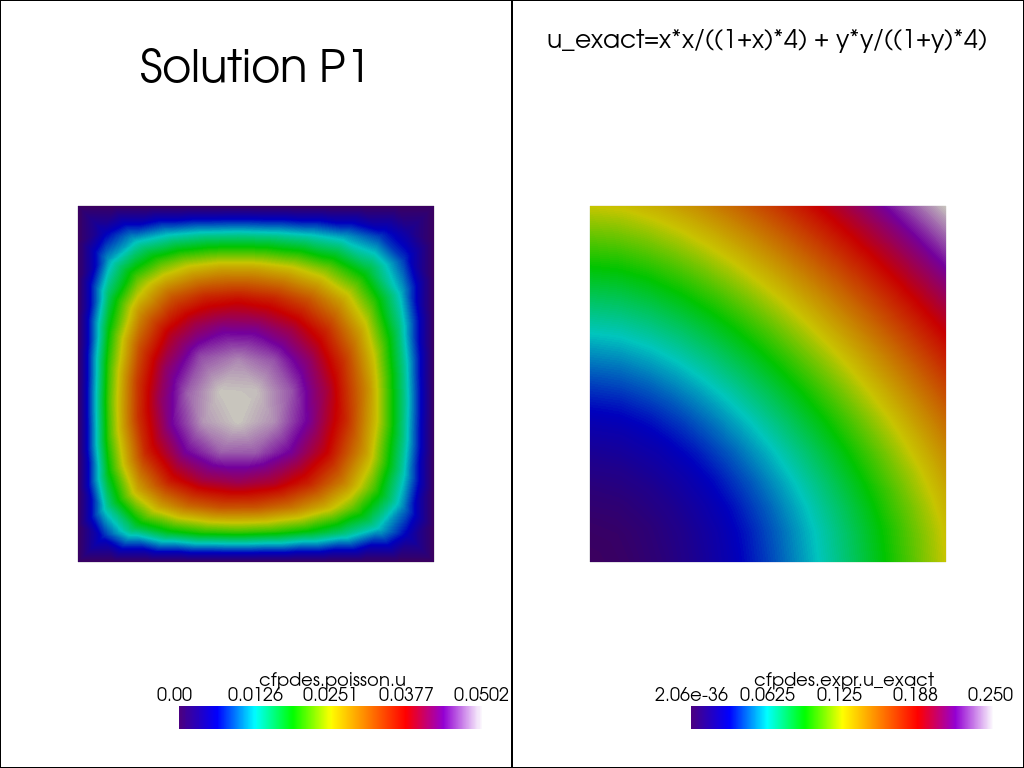

Solving the laplacian problem for hsize = 0.1...
>> load network /workspaces/2024-m1-scimba-feelpp/feelppdb/feelpp_cfpde/np_1/networks/test.pth
network was not loaded from file: training needed
epoch     0: current loss = 1.01e+00
epoch     0: best loss = 1.01e+00
epoch     1: best loss = 8.92e-01
epoch     2: best loss = 7.04e-01
epoch     3: best loss = 3.78e-01
epoch     4: best loss = 5.90e-02
epoch    11: best loss = 5.40e-02
epoch    12: best loss = 3.56e-02
epoch    15: best loss = 2.90e-02
epoch    20: best loss = 1.87e-02
epoch    21: best loss = 1.10e-02
epoch    25: best loss = 8.90e-03
epoch    30: best loss = 5.83e-03
epoch    34: best loss = 3.09e-03
epoch    43: best loss = 3.08e-03
epoch    47: best loss = 2.33e-03
epoch    51: best loss = 2.06e-03
epoch    52: best loss = 2.02e-03
epoch    56: best loss = 1.81e-03
epoch    60: best loss = 1.62e-03
epoch    64: best loss = 1.40e-03
epoch    65: best loss = 1.34e-03
epoch    68: best loss = 1.27e-03
epoch    69: best los

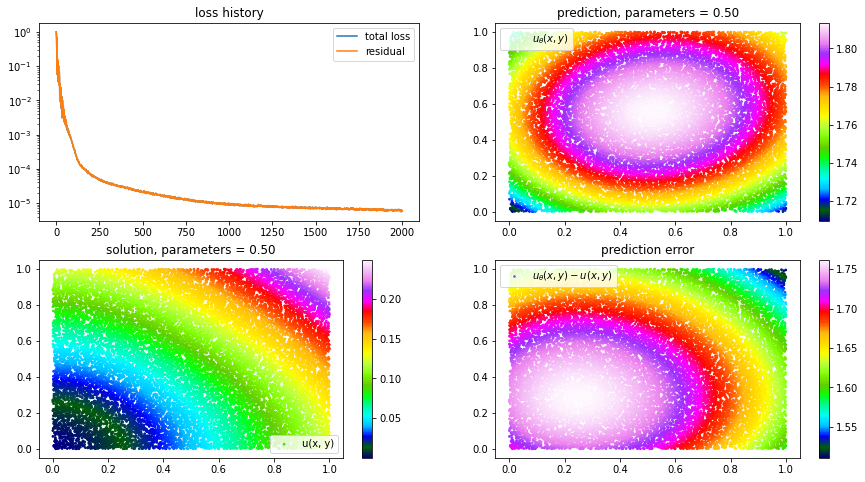

Info    : Reading 'omega-2.geo'...
Info    : Done reading 'omega-2.geo'
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 30%] Meshing curve 2 (Line)
Info    : [ 60%] Meshing curve 3 (Line)
Info    : [ 80%] Meshing curve 4 (Line)
Info    : Done meshing 1D (Wall 0.000311694s, CPU 0.000522s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.00508613s, CPU 0.005123s)
Info    : 144 nodes 290 elements
Info    : Writing 'omega-2d.msh'...
Info    : Done writing 'omega-2d.msh'
solution =  [[1.70743205]
 [1.71634809]
 [1.7591099 ]
 [1.73052422]
 [1.7253279 ]
 [1.73885874]
 [1.74828194]
 [1.75383585]
 [1.75573559]
 [1.75417187]
 [1.74931209]
 [1.74130323]
 [1.73027571]
 [1.73611356]
 [1.75185747]
 [1.7638393 ]
 [1.77229403]
 [1.77743113]
 [1.77943534]
 [1.77846901]
 [1.77467547]
 [1.76818311]
 [1.76895355]
 [1.77624693]
 [1.78090939]
 [1.78285151]
 [1.78197173]
 [1.77815326]
 [1.77126175]
 [1.76114396]
 [1.74

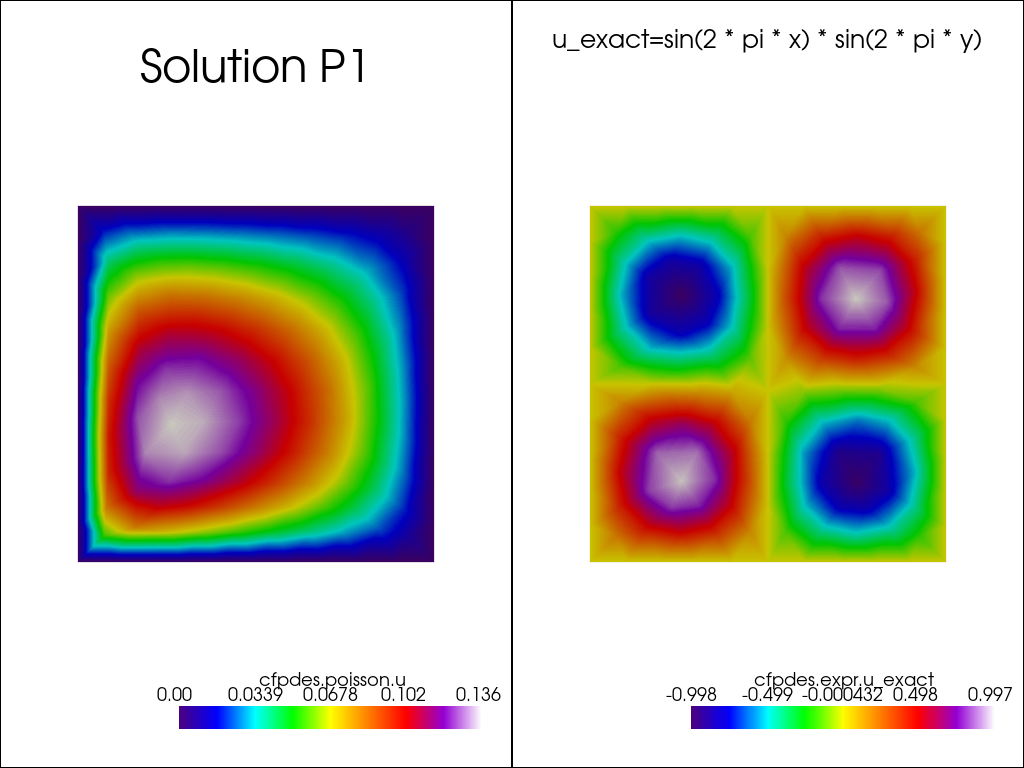

Solving the laplacian problem for hsize = 0.1...
>> load network /workspaces/2024-m1-scimba-feelpp/feelppdb/feelpp_cfpde/np_1/networks/test.pth
network was not loaded from file: training needed
epoch     0: current loss = 9.82e-01
epoch     0: best loss = 9.82e-01
epoch     1: best loss = 9.02e-01
epoch     2: best loss = 7.57e-01
epoch     3: best loss = 5.45e-01
epoch     4: best loss = 2.67e-01
epoch     5: best loss = 6.85e-02
epoch    22: best loss = 5.40e-02
epoch    23: best loss = 4.13e-02
epoch    24: best loss = 3.32e-02
epoch    25: best loss = 3.20e-02
epoch    29: best loss = 2.85e-02
epoch    30: best loss = 2.62e-02
epoch    31: best loss = 2.22e-02
epoch    32: best loss = 1.92e-02
epoch    35: best loss = 1.86e-02
epoch    36: best loss = 1.72e-02
epoch    37: best loss = 1.69e-02
epoch    38: best loss = 1.57e-02
epoch    42: best loss = 1.49e-02
epoch    43: best loss = 1.43e-02
epoch    44: best loss = 1.30e-02
epoch    49: best loss = 1.26e-02
epoch    52: best los

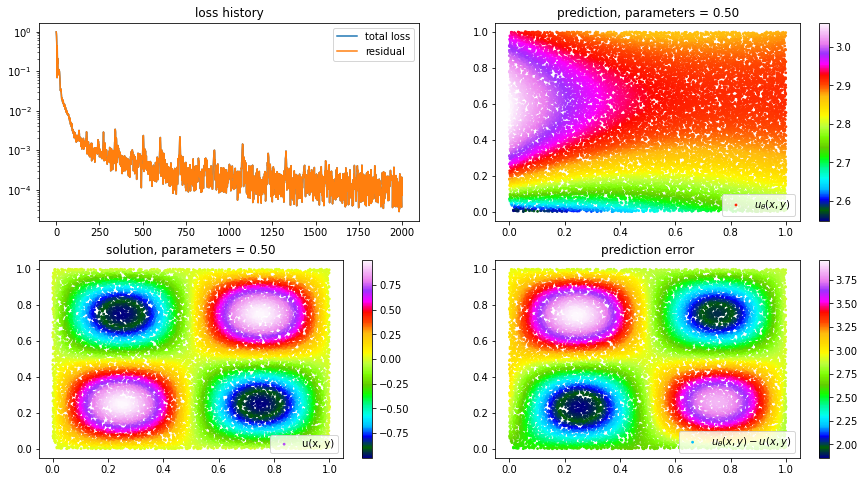

Info    : Reading 'omega-2.geo'...
Info    : Done reading 'omega-2.geo'
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 30%] Meshing curve 2 (Line)
Info    : [ 60%] Meshing curve 3 (Line)
Info    : [ 80%] Meshing curve 4 (Line)
Info    : Done meshing 1D (Wall 0.000227632s, CPU 0.000312s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.00471529s, CPU 0.004726s)
Info    : 144 nodes 290 elements
Info    : Writing 'omega-2d.msh'...
Info    : Done writing 'omega-2d.msh'
solution =  [[2.51495964]
 [2.75615912]
 [2.87560873]
 [2.93861784]
 [2.57545859]
 [2.59559956]
 [2.61343185]
 [2.63285403]
 [2.65355667]
 [2.67496286]
 [2.69639747]
 [2.71725798]
 [2.73722173]
 [2.80313032]
 [2.84132351]
 [2.87096805]
 [2.89243676]
 [2.90618482]
 [2.91269774]
 [2.9124549 ]
 [2.90591062]
 [2.89349167]
 [2.87123477]
 [2.8673881 ]
 [2.86461081]
 [2.86357353]
 [2.86503794]
 [2.86980892]
 [2.87870613]
 [2.89256725]
 [2.91

In [11]:


# # 2D with varying anisotropy
P = Poisson(dim = 2)
u_exact = 'x*x/((1+x)*4) + y*y/((1+y)*4)'
P(rhs='1', diff='{1+x,0,0,1+y}', plot='d1.png', u_exact = u_exact)
P(rhs='1+ x-x', diff='(1+x,0,0,1+y)', solver='scimba', u_exact = u_exact)

P(rhs='1', diff='{x,y,-y,x+y}',  plot='d3.png')
P(rhs='1+ x-x', diff='(x,y,-y,x+y)',  solver='scimba')

